## Analyze NN model

Notebook to analyze predictions of models CNN, GRU and CNN_Att. 

Run as is to load and compute metrics for the provided CNN_Att model.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from constants import *

import utils
import model_functions as fun
import models

### Load data and model

In [4]:
# Load inputs

# Embedding layer
wv_embedding_matrix, row_dict = utils.load_w2v_emb(w2v_vec_size=W2V_SIZE, verbose=1)

# x, y
x, y, mlb = utils.load_w2v_proc_inputs(max_words=MAX_LENGTH, verbose=1)


# Instantiate model_args
model_args = fun.model_args(x,y)

Dataset: MIMIC
Embedding matrix shape: (35215, 300)
Train set: X: (47719, 2000) Y: (47719, 6918)
Val set: X: (1631, 2000) Y: (1631, 6918)
Test set: X: (3372, 2000) Y: (3372, 6918)


In [5]:
# Choose model

MODEL_NAME = 'cnn_att'

In [6]:
## Run this cell only if you must define parameters. If this is the lastest model you trained use args=None below to restore used args.

class args:

    def __init__(self, MODEL_NAME):
        # Put your parameters here
        args.MODEL_NAME = MODEL_NAME
        args.lr = 0
        args.kernel_size = 10
        args.units = 500
        args.activation = 'tanh'

args = args(MODEL_NAME)

In [8]:
# Load model and weights
model_args.model = utils.load_model_custom(model_args, wv_embedding_matrix, args=args)

##### Compute predictions

In [10]:
%%time 

# Predict (this may take a while)
model_args.predict()

CPU times: user 6min 48s, sys: 3min 51s, total: 10min 39s
Wall time: 9min 38s


### Sweep through different $k$ values
- where $t$ is the threshold for prediction, i.e., only scores higher than $t$ are accounted as predicted labels

##### Compute best $t$ (in terms of F1 val)

In [12]:
ts = np.linspace(0.01,0.99, 99)

model_args = fun.sweep_thresholds(model_args, thresholds=ts, predicted_model=True)

Best thresh: 0.25
F1 @ 0.25: 

--Train micro-- metrics:
F1			Precision		Recall
0.6101478326921125	0.6110778492450166	0.6092206426740849
--Val micro-- metrics:
F1			Precision		Recall
0.540734151137747	0.5760961739911209	0.5094622612378138
--Test micro-- metrics:
F1			Precision		Recall
0.5366900175131348	0.5711623139109568	0.5061419988851498


##### Plot Validation metrics at different $t$ values

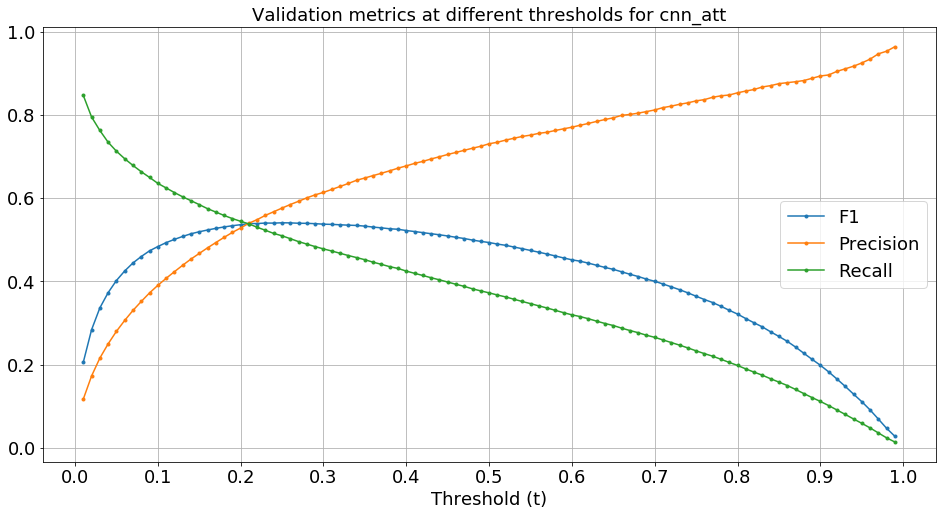

In [13]:
threshold_plot = (pd.DataFrame(model_args.sweep_results)
                  .set_index('thresholds')
                  )

best_result = threshold_plot.sort_values('f1_val', ascending=False)['f1_val'].reset_index().iloc[0]

ax1 = (threshold_plot
        .drop('avg_val_pred',axis=1)
        .drop('best_f1_val',axis=1)
        .drop('best_threshold', axis=1)
        .plot(figsize=(16, 8),
        fontsize=18,
        xticks=np.linspace(0,1,11),
        style='.-'))

plt.xlabel('Threshold (t)', fontsize=18)
plt.title('Validation metrics at different thresholds for %s' %MODEL_NAME, fontsize=18)
plt.legend(['F1','Precision','Recall'], fontsize=18)
plt.grid()


plt.show()

##### Plot Validation average output list size at different $t$ values

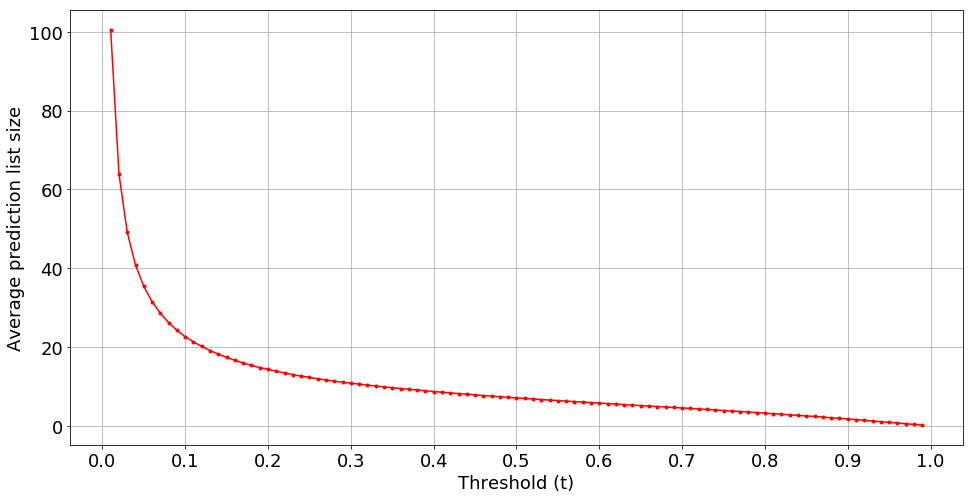

In [14]:
threshold_plot.plot(y='avg_val_pred', figsize=(16,8), fontsize=18, style='r.-', legend=False)
plt.xlabel('Threshold (t)',fontsize=18)
plt.ylabel('Average prediction list size',fontsize=18)
plt.xticks(np.linspace(0,1,11))
plt.grid()
plt.show()

### Sweep through different $k$ values
- where $k$ is a fixed output-size, i.e., only the $k$ highest scored labels for a sample will be predicted

##### Compute best $k$ (in terms of F1 val)

In [15]:
ks = np.linspace(1,20,20, dtype=int)

model_args = fun.sweep_k(model_args, ks=ks, predicted_model=True)

Best k: 13
F1 @ 13: 

--Train micro-- metrics:
F1			Precision		Recall
0.5577721983627566	0.5251738140105457	0.5946852707744653
--Val micro-- metrics:
F1			Precision		Recall
0.5082968636032092	0.5258689808046031	0.4918611319423001
--Test micro-- metrics:
F1			Precision		Recall
0.5008615738081561	0.5271466374669221	0.4770733117245081


##### Plot Validation metrics at different $k$ values

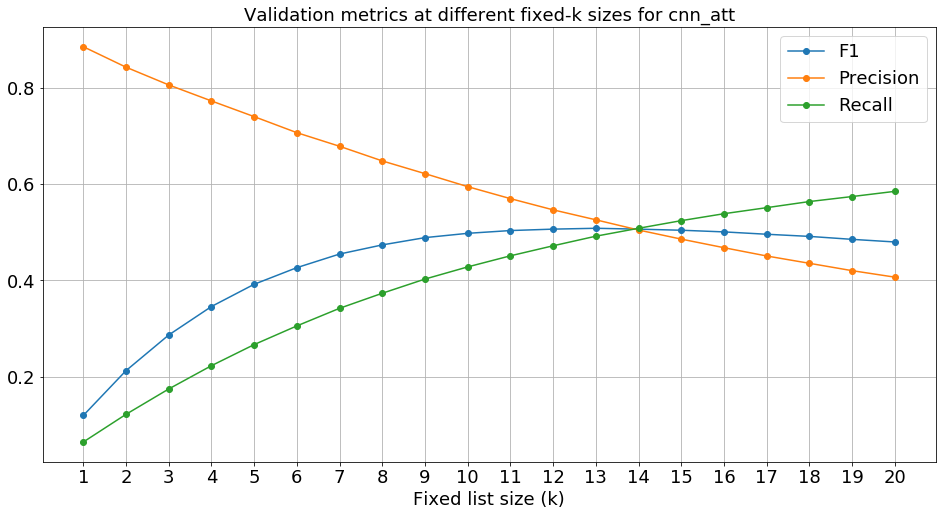

In [16]:
k_plot = (pd.DataFrame(model_args.sweepk_results)
                  .set_index('ks')
                  )

ax1 = (k_plot
        .plot(figsize=(16, 8),
        fontsize=18,
        style='o-'))

plt.xticks(ks)
plt.xlabel('Fixed list size (k)', fontsize=18);
plt.title('Validation metrics at different fixed-k sizes for %s' %MODEL_NAME, fontsize=18)
plt.legend(['F1','Precision','Recall'], fontsize=18);
plt.grid()

plt.show()